# 随机森林分类模型完整流程 - 柯磊

展示使用随机森林进行乳腺癌分类的完整流程，包含数据预处理、模型训练、评估和可视化。

## 1. 数据加载与预处理

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, cross_val_score, \
                                   learning_curve, GridSearchCV, \
                                   StratifiedKFold)
from sklearn.metrics import (accuracy_score, confusion_matrix, \
                           ConfusionMatrixDisplay, classification_report, \
                           roc_curve, auc, f1_score, precision_recall_curve)
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 加载数据
data = pd.read_csv('data.csv')
X = data.drop(['diagnosis', 'Unnamed: 32'], axis=1)
y = data['diagnosis'].map({'B': 0, 'M': 1})

# 查看数据前5行
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## 2. 数据集划分与特征缩放

In [2]:
# 数据集划分（60%训练，20%验证，20%测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# 特征缩放
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print('训练集样本数:', len(X_train))
print('验证集样本数:', len(X_val))
print('测试集样本数:', len(X_test))

训练集样本数: 341
验证集样本数: 114
测试集样本数: 114


## 3. 超参数调优与可视化 

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Anaconda\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


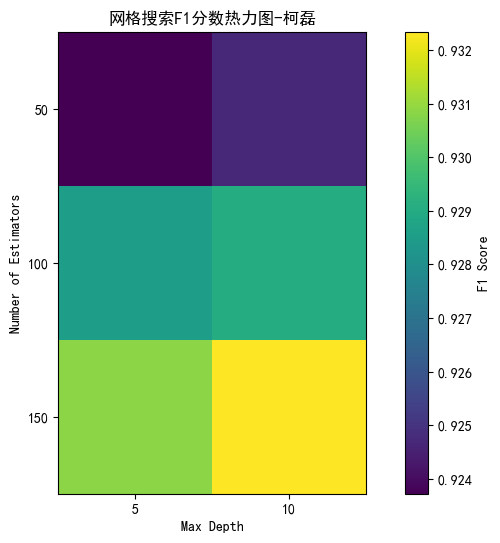

最佳参数: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 150, 'oob_score': True}
验证集F1: 0.943


In [3]:
# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_leaf': [1, 2, 4],
    'oob_score': [True, False]
}

# 网格搜索
rf = RandomForestClassifier(random_state=42, bootstrap=True)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 参数搜索热力图
results = pd.DataFrame(grid_search.cv_results_)
pivot = results.pivot_table(index='param_n_estimators', \
                           columns='param_max_depth', \
                           values='mean_test_score')

plt.figure(figsize=(10, 6))
plt.imshow(pivot, cmap='viridis')
plt.colorbar(label='F1 Score')
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')
plt.title('网格搜索F1分数热力图-柯磊')
plt.show()

# 输出最佳参数
best_rf = grid_search.best_estimator_
print(f'最佳参数: {grid_search.best_params_}')
print(f'验证集F1: {f1_score(y_val, best_rf.predict(X_val)):.3f}')

## 4. 交叉验证评估 

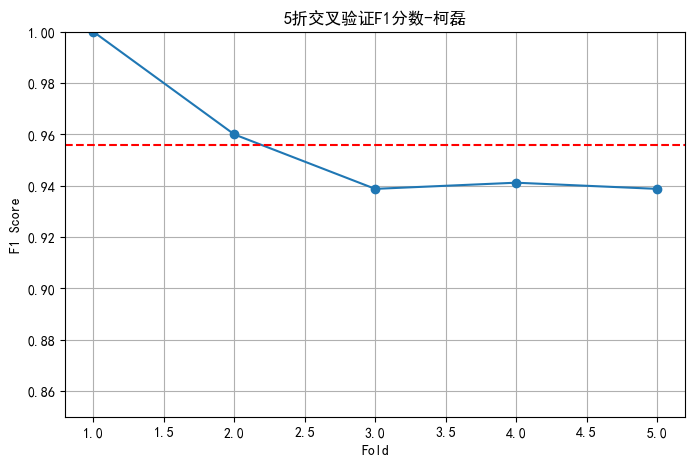

In [4]:
# 5折交叉验证
cv_scores = cross_val_score(best_rf, X_train, y_train, \
                          cv=StratifiedKFold(5), scoring='f1')

plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), cv_scores, 'o-')
plt.axhline(np.mean(cv_scores), color='red', linestyle='--')
plt.title('5折交叉验证F1分数-柯磊')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.ylim(0.85, 1.0)
plt.grid()
plt.show()

## 5. 测试集评估 

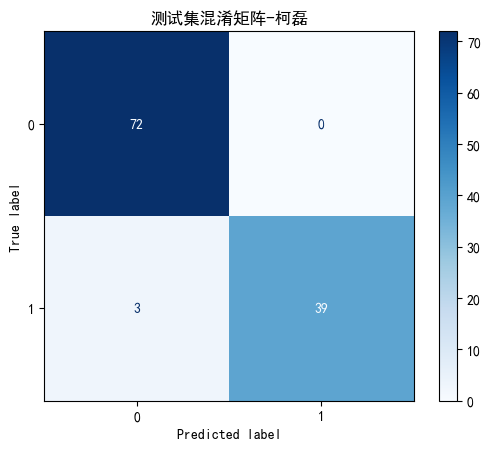

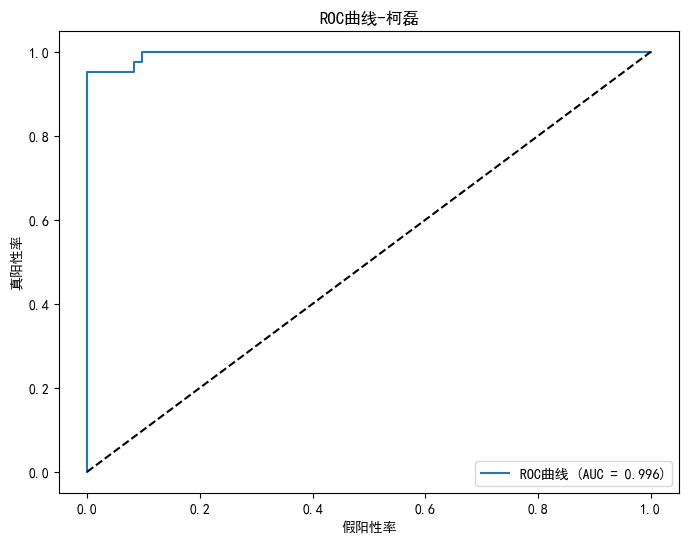

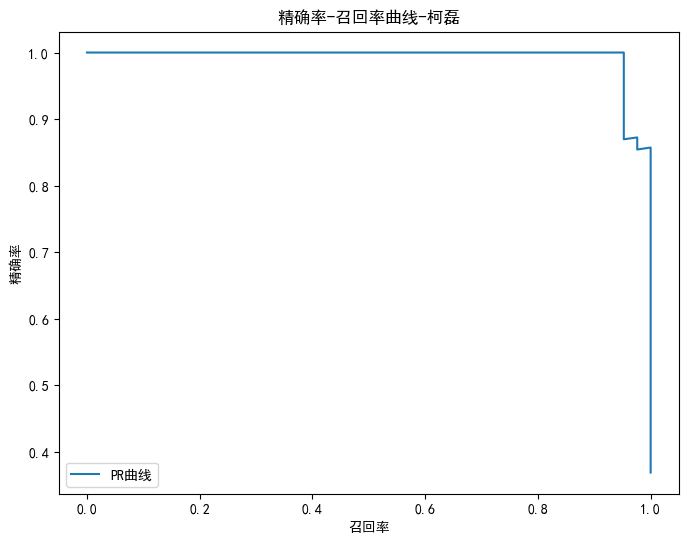

In [5]:
# 测试集预测
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title('测试集混淆矩阵-柯磊')
plt.show()

# ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC曲线 (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('ROC曲线-柯磊')
plt.legend()
plt.show()

# PR曲线
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR曲线')
plt.xlabel('召回率')
plt.ylabel('精确率')
plt.title('精确率-召回率曲线-柯磊')
plt.legend()
plt.show()

## 6. 特征重要性分析 

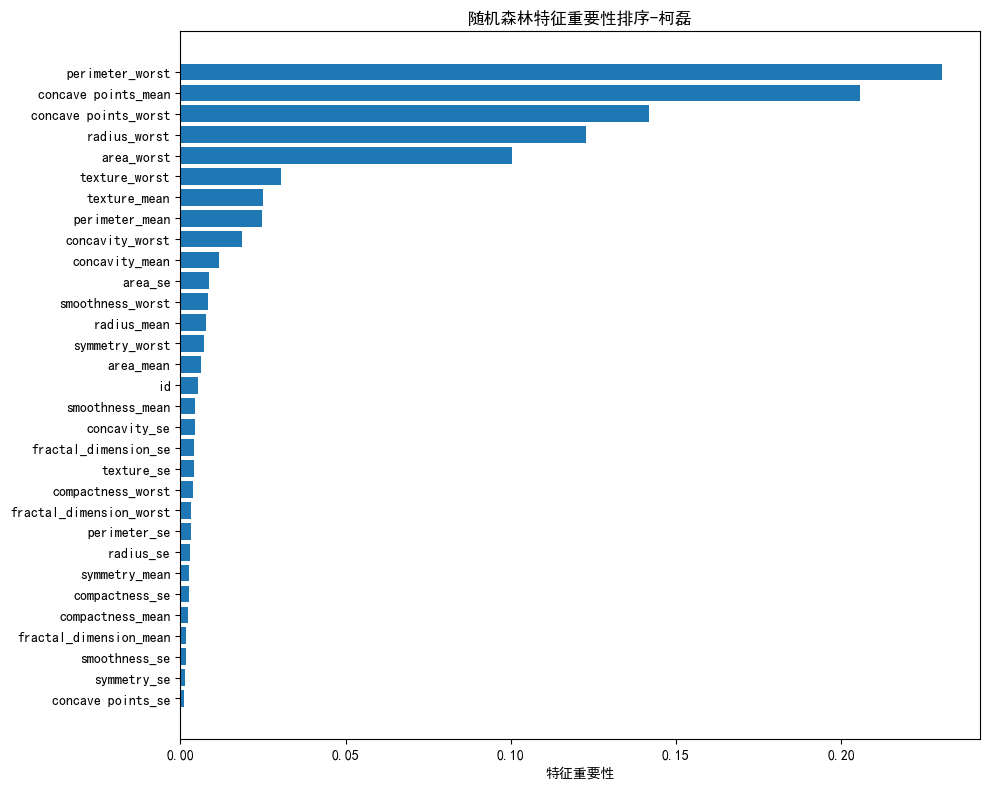

In [6]:
# 特征重要性
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('特征重要性')
plt.title('随机森林特征重要性排序-柯磊')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. 学习曲线分析 

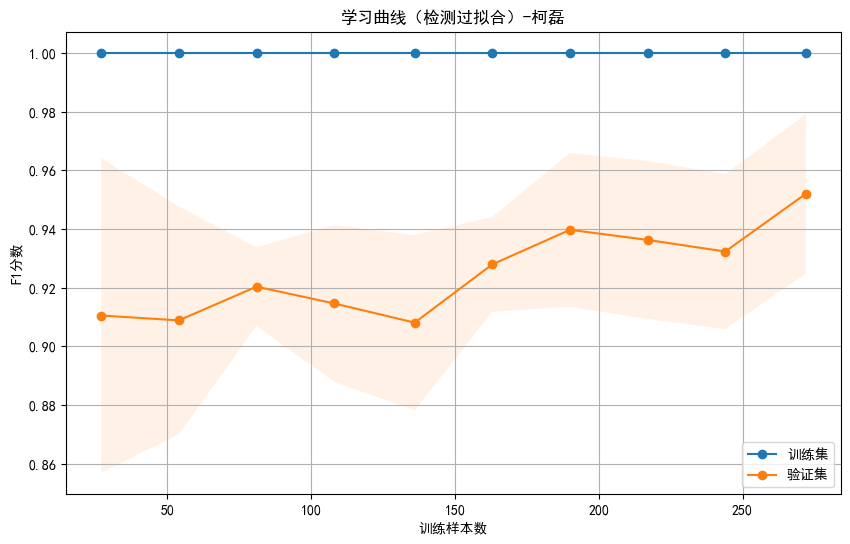

In [7]:
# 学习曲线
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='训练集')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='验证集')
plt.fill_between(train_sizes, \
                np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                np.mean(train_scores, axis=1) + np.std(train_scores, axis=1),
                alpha=0.1)
plt.fill_between(train_sizes,
                np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                np.mean(val_scores, axis=1) + np.std(val_scores, axis=1),
                alpha=0.1)
plt.xlabel('训练样本数')
plt.ylabel('F1分数')
plt.title('学习曲线（检测过拟合）-柯磊')
plt.legend()
plt.grid()
plt.show()

## 8. 最终模型评估报告 

In [9]:
# 模型评估报告
print('\n=== 最终模型评估 ===')
print(f'测试集准确率: {accuracy_score(y_test, y_pred):.3f}')
print(f'测试集F1分数: {f1_score(y_test, y_pred):.3f}')
print('\n分类报告:')
print(classification_report(y_test, y_pred, target_names=['良性', '恶性']))
print(f'袋外分数(OOB): {best_rf.oob_score_:.3f}' if hasattr(best_rf, 'oob_score_') else '')


=== 最终模型评估 ===
测试集准确率: 0.974
测试集F1分数: 0.963

分类报告:
              precision    recall  f1-score   support

          良性       0.96      1.00      0.98        72
          恶性       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

袋外分数(OOB): 0.962
